In [ ]:
!git clone https://github.com/LetteraUnica/NLP-units.git

In [2]:
%cd NLP-units/final-project/

/content/NLP-units/final-project


In [3]:
import numpy as np
import pandas as pd
import pylab as pl
import os
from IPython.display import clear_output
import time


from sklearn.preprocessing import LabelEncoder

import torch
from torch import nn
from torch.nn import functional as F

from CNN import *
from LSTM import *
from tokenizer import *
from document_cleaner import *
from utils import *

# CNN / LSTM

In [4]:
train_data = pd.read_csv("data/train_data.csv")
test_data = pd.read_csv("data/test_data.csv")

In [5]:
X_train = train_data["full_text_cleaned"]
y_train = train_data["category"]
X_test = test_data["full_text_cleaned"]
y_test = test_data["category"]

In [6]:
# Encode y labels
le = LabelEncoder().fit(y_train)
y_train = le.transform(y_train)
y_test = le.transform(y_test)

y_train = torch.tensor(y_train).long()
y_test = torch.tensor(y_test).long()

In [7]:
# Fit the tokenizer
tokenizer = MyTokenizer(min_df=0.00001, max_df=1.)
tokenizer.fit(X_train)

# Tokenize the sequences
X_train = tokenizer.transform(X_train)
X_test = tokenizer.transform(X_test)

In [8]:
from torch.utils.data import Dataset, DataLoader
class MatrixLoader(Dataset):
    """Simple dataloader given the data matrix X and response y
    batch is assumed to be the first dimension"""
    def __init__(self, X, y, classification=True):
        self.X = X
        self.y = y

        if classification:
            self.y = self.y.to(int)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.y[index]


# Custom data collation function to perform dynamic padding
def my_collate(batch):
    data = [item[0] for item in batch]
    data = torch.tensor(pad_to_max_length(data, 0), dtype=torch.long)
    target = [item[1] for item in batch]
    target = torch.LongTensor(target)
    return [data, target]

In [15]:
# Create datasets
train_set= MatrixLoader(X_train, y_train)
test_set = MatrixLoader(X_test, y_test)

# Create dataloaders
train_loader = DataLoader(train_set, batch_size=256, shuffle=True, collate_fn=my_collate)
test_loader = DataLoader(test_set, batch_size=256, shuffle=True, collate_fn=my_collate)

In [10]:
embedding_dim = 256 #@param {type:"integer"}

In [13]:
# Define CNN model
net = CNN(embedding_dim=embedding_dim, n_resnets=10, blocks_per_resnet=1, kernel_size=3)

model = TextClassifier(tokenizer.get_vocab_size(), embedding_dim=embedding_dim, out_dim=y_train.max()+1, net=net)

In [16]:
# Define LSTM model
net = LSTM(embedding_dim=embedding_dim, n_lstms=5, bidirectional=True)

model = TextClassifier(tokenizer.get_vocab_size(), embedding_dim=embedding_dim, out_dim=y_train.max()+1, net=net)
model.classifier = nn.Linear(embedding_dim*2, y_train.max()+1)

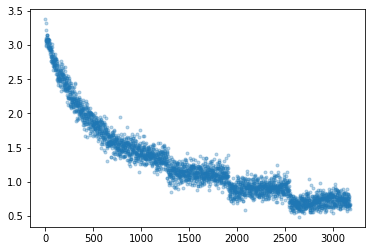

F1 macro: 0.37
F1 weighted: 0.57


In [17]:
#@title Train CNN or LSTM {vertical-output: true}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), 1e-3)
criterion = nn.CrossEntropyLoss()

losses = []
eval_loss = []
for epoch in range(5):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        losses.append(loss.cpu().item())

    # Print eval loss
    clear_output(True)
    pl.plot(losses, '.', alpha=0.3)
    pl.show()
    y_pred = []
    y_true = []
    model.eval()
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            y_pred.extend([max.cpu().item() for max in torch.argmax(output, dim=1)])
            y_true.extend([y.cpu().item() for y in target])

    get_f1_scores(y_pred, y_true)

In [18]:
# Test the model
y_pred = []
y_true = []
start = time.time()
model.eval()
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data, target = data.to(device), target.to(device)
        output = model(data)
        y_pred.extend([max.cpu().item() for max in torch.argmax(output, dim=1)])
        y_true.extend([y.cpu().item() for y in target])

print("time per document: ", (time.time() - start) / len(test_set))
get_f1_scores(y_pred, y_true)

time per document:  0.0001618237164739909
F1 macro: 0.37
F1 weighted: 0.57


# Transformer

In [19]:
!pip install transformers
!pip install datasets
clear_output()

In [20]:
# Prepare data for HuggingFace transformers
train_data = pd.read_csv("data/train_data.csv")
test_data = pd.read_csv("data/test_data.csv")

train_data = train_data.loc[:, ["full_text", "category"]]
test_data = test_data.loc[:, ["full_text", "category"]]

train_data.rename(columns={"full_text": "text", "category": "label"}, inplace=True)
test_data.rename(columns={"full_text": "text", "category": "label"}, inplace=True)

In [21]:
# Encode y labels
le = LabelEncoder().fit(train_data["label"])
train_data["label"] = le.transform(train_data["label"])
test_data["label"] = le.transform(test_data["label"])

In [22]:
from datasets import Dataset
train_set = Dataset.from_pandas(train_data)
test_set = Dataset.from_pandas(test_data)

In [ ]:
# Tokenize Sequences
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True)

tokenized_train_dataset = train_set.map(tokenize_function, batched=True)
tokenized_test_dataset = test_set.map(tokenize_function, batched=True)

In [24]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
from datasets import load_metric

metric = load_metric("accuracy") # Use accuracy since F1 doesn't work

In [26]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [27]:
# Shuffle train/eval set
train_dataset = tokenized_train_dataset.shuffle(seed=42)
eval_dataset = tokenized_test_dataset.shuffle(seed=42)

In [ ]:
# Import distilbert-base-uncased model
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=train_data["label"].max() + 1)

In [30]:
# Set train args
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=1,
    evaluation_strategy="epoch",
    save_steps=2000,
)

In [31]:
# Train for 1 epoch
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    data_collator=data_collator
)

trainer.train()

The following columns in the training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 162378
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 10149


Epoch,Training Loss,Validation Loss,Accuracy
1,0.874200,1.050088,0.688189


Saving model checkpoint to ./results/checkpoint-2000
Configuration saved in ./results/checkpoint-2000/config.json
Model weights saved in ./results/checkpoint-2000/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-2000/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-2000/special_tokens_map.json
Saving model checkpoint to ./results/checkpoint-4000
Configuration saved in ./results/checkpoint-4000/config.json
Model weights saved in ./results/checkpoint-4000/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-4000/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-4000/special_tokens_map.json
Saving model checkpoint to ./results/checkpoint-6000
Configuration saved in ./results/checkpoint-6000/config.json
Model weights saved in ./results/checkpoint-6000/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-6000/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-6000/special

TrainOutput(global_step=10149, training_loss=1.0722137550401363, metrics={'train_runtime': 1317.183, 'train_samples_per_second': 123.277, 'train_steps_per_second': 7.705, 'total_flos': 3327730640701848.0, 'train_loss': 1.0722137550401363, 'epoch': 1.0})

In [32]:
# Compute f1 scores and prediction time

y_true = []
y_pred = []
batch_size = 64
model.eval()
start = time.time()
for i in range(0, len(eval_dataset), batch_size):
    batch = eval_dataset[i:i+batch_size]
    input = tokenizer(batch["text"], truncation=True)
    y_true.extend(batch["label"])
    input = data_collator(input)
    input = torch.LongTensor(input["input_ids"]).cuda()
    with torch.no_grad():
        outputs = model(input)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    y_pred.extend([prediction.item() for prediction in predictions.cpu()])

print("time per document: ", (time.time() - start) / len(eval_dataset))
get_f1_scores(y_true, y_pred)

time per document:  0.0016265599327043774
F1 macro: 0.45
F1 weighted: 0.68
